# Just operation policies of Guadalajara’s Aquapheric under drought conditions

## Formulation 1 plan. No uncertainties except flows
1. Define ranges of the flow under drought based on the average 2020 flow. Currently set to 0 and 150% of the average flow for all sources. L
2. Define the supplied demand ratio of each supply area + a justice as objectives (min for now)
3. Aquapheric flows as levers currently. Later Original RBFs (inputs: water flows5, outputs: AqP flows4) (not implemented)
5. Conduct an optimization (n policies, x scenarios (water flows)) This will produce a dataframe with n policies that generate n sets of objectives for each scenario.
7. Calculate an indicator of performance for each policy and each objective across all the scenarios. (average for now)
8. Visualize

### Unresolved issues
* How to visualize other outcomes when using Optimize Evaluator


In [3]:


from ema_workbench import (Model, RealParameter, ScalarOutcome,
                           MultiprocessingEvaluator, ema_logging,
                           Constant, Scenario, Constraint,optimize)


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from AMG_function import AMG_model_function
import numpy as np

outcomes = AMG_model_function(chapala_flow= 4.9, calderon_flow= 0.6, zapotillo_flow= 0.4, pozos_flow= 1.6, toluquilla_flow= 0.6, 
                aqp1_PP2_to_PP3=-0.2, aqp2_PP3_to_Pozos=-0.2, aqp3_Pozos_to_Toluquilla=-0.3, aqp4_Toluquilla_to_PP1=-0.2)



print(outcomes)




{'supplied_PP1': 1.9813492400000003, 'supplied_PP2': 0.6927895000000001, 'supplied_PP3': 0.8125, 'supplied_Toluquilla': 0.60641126, 'supplied_Pozos': 0.8762000000000001, 'demand_PP1': 2.32436, 'demand_PP2': 0.6546, 'demand_PP3': 0.76724, 'demand_Toluquilla': 0.67242, 'demand_Pozos': 1.04161, 'delivered_PP1': 3.9690000000000007, 'delivered_PP2': 0.931, 'delivered_PP3': 1.0, 'delivered_Toluquilla': 0.6, 'delivered_Pozos': 1.6, 'supplied_demand_PP1': 0.85243, 'supplied_demand_PP2': 1.05834, 'supplied_demand_PP3': 1.05899, 'supplied_demand_Toluquilla': 0.90183, 'supplied_demand_Pozos': 0.8412, 'supplied_demand_deficit_PP1': 0.14756999999999998, 'supplied_demand_deficit_PP2': 0.05834000000000006, 'supplied_demand_deficit_PP3': 0.0589900000000001, 'supplied_demand_deficit_Toluquilla': 0.09816999999999998, 'supplied_demand_deficit_Pozos': 0.15880000000000005, 'supply_percapita_PP1': 108.25828, 'supply_percapita_PP2': 134.40947, 'supply_percapita_PP3': 134.49214, 'supply_percapita_Toluquilla':

# 1. Tests for a single drought scenario and no uncertainty

## 1.1 Formulation 1 with only disagregated supplied demand outcomes

In [8]:
from AMG_function import AMG_model_function

#Setting the stage
performance_indicator_to_optimize = "supplied_demand_deficit"
experiment_name = "supplied demand deficit"

#Parameters
rounding_outcomes = 5
rounding_levers = 4

ema_logging.log_to_stderr(ema_logging.INFO)

ZA_names = ["PP1", "PP2", "PP3", "Toluquilla", "Pozos"]

#instantiate the model
AMG_model = Model("AMGmodel", function = AMG_model_function)

#Levers

AMG_model.levers = [RealParameter('aqp1_PP2_to_PP3',-1,1),
                    RealParameter('aqp2_PP3_to_Pozos',-1,1),
                    RealParameter('aqp3_Pozos_to_Toluquilla',-1,1),
                    RealParameter('aqp4_Toluquilla_to_PP1',-1,1)]

#Outcomes

maximizing_outcomes = [f"supplied_demand_{ZA}" for ZA in ZA_names] #separate lists of maximizing and minizmizing objectives for simplicity
info_outcomes = [f"supplied_{ZA}" for ZA in ZA_names]
minimizing_outcomes = []

AMG_model.outcomes = [ScalarOutcome(scalar_outcome, kind=ScalarOutcome.MAXIMIZE) for scalar_outcome in maximizing_outcomes] + [
    ScalarOutcome(minimizing_outcome, kind=ScalarOutcome.MINIMIZE) for minimizing_outcome in minimizing_outcomes] + [
    ScalarOutcome(info_outcome, kind=ScalarOutcome.INFO) for info_outcome in info_outcomes]


In [9]:
ZA_names

['PP1', 'PP2', 'PP3', 'Toluquilla', 'Pozos']

In [10]:
#Using supplied demand and a non negatyive constrain
ema_logging.log_to_stderr(ema_logging.INFO)

#Scenario setting
drougth_multiplier = 0.5
scenario1 = Scenario("drought1", 
                    chapala_flow = 6.9*drougth_multiplier, 
                    calderon_flow = 1*drougth_multiplier, 
                    zapotillo_flow = 1*drougth_multiplier, 
                    pozos_flow = 2.3*drougth_multiplier, 
                    toluquilla_flow = 0.5*drougth_multiplier)

scenario_2020 = Scenario("drought_2020", 
                    chapala_flow = 7.1*drougth_multiplier, 
                    calderon_flow = 0*drougth_multiplier, 
                    zapotillo_flow = 0*drougth_multiplier, 
                    pozos_flow = 2.2*drougth_multiplier, 
                    toluquilla_flow = 0.4*drougth_multiplier)


scenario = scenario_2020


non_negative_outcomes = [f"supplied_{ZA}" for ZA in ZA_names]
constraints = [Constraint("non_negative_constrain", outcome_names= outcome, 
                         function=lambda x: max(0, -x)) for outcome in non_negative_outcomes]

with MultiprocessingEvaluator(AMG_model) as evaluator:
    results = evaluator.optimize(
        nfe=1000, searchover="levers", epsilons=[0.05] * 5, constraints = constraints, reference=scenario
    )

results.head(10)

[MainProcess/INFO] pool started with 8 workers
  0%|                                                 | 0/1000 [00:00<?, ?it/s]

1083it [00:07, 152.08it/s]                                                     
[MainProcess/INFO] optimization completed, found 361 solutions
[MainProcess/INFO] terminating pool


,aqp1_PP2_to_PP3,aqp2_PP3_to_Pozos,aqp3_Pozos_to_Toluquilla,aqp4_Toluquilla_to_PP1,supplied_demand_PP1,supplied_demand_PP2,supplied_demand_PP3,supplied_demand_Toluquilla,supplied_demand_Pozos
0,-0.955765,-0.142759,-0.222167,-0.599077,0.47203,1.55438,0.29397,0.91279,0.60931
1,0.183950,-0.484171,-0.009390,-0.092886,0.61358,0.42267,1.54877,0.62916,0.26348
2,0.372148,0.841186,0.481548,-0.211062,0.58053,0.23580,0.58538,1.21797,0.78418
3,0.329434,-0.868109,-0.471188,-0.268092,0.56459,0.27821,1.99729,0.35212,0.31207
4,-0.728426,0.308638,-0.133227,-0.666879,0.45307,1.32864,0.10415,1.06431,0.83550
5,-0.158218,-0.109052,0.504836,-0.571122,0.47985,0.76244,0.94109,1.58853,0.17667
6,-0.361660,-0.816859,-0.583888,-0.630762,0.46317,0.96445,1.36838,0.59376,0.41438
7,-0.392148,0.750855,0.991154,-0.061949,0.62223,0.99472,0.01440,1.56644,0.40980
8,0.211467,0.600265,0.250231,0.610625,0.81032,0.39535,0.65336,0.20007,0.77819
9,-0.186711,-0.588038,-0.465247,0.078835,0.66160,0.79073,1.32274,0.02251,0.48313


## 1.2 Formulation with supplied demand deficit

In [11]:
#Setting the stage

performance_indicator_to_optimize = "supplied_demand_deficit"
experiment_name = "supplied demand deficit"

#Parameters
rounding_outcomes = 5
rounding_levers = 4

#Scenario setting
drougth_multiplier = 0.5
scenario1 = Scenario("drought1", 
                    chapala_flow = 6.9*drougth_multiplier, 
                    calderon_flow = 1*drougth_multiplier, 
                    zapotillo_flow = 1*drougth_multiplier, 
                    pozos_flow = 2.3*drougth_multiplier, 
                    toluquilla_flow = 0.5*drougth_multiplier)
scenario = scenario1



In [12]:
from AMG_function import AMG_model_function

ema_logging.log_to_stderr(ema_logging.INFO)

ZA_names = ["PP1", "PP2", "PP3", "Toluquilla", "Pozos"]

#instantiate the model
AMG_model = Model("AMGmodel", function = AMG_model_function)

#Levers
AMG_model.levers = [RealParameter('aqp1_PP2_to_PP3',-1,1),
                    RealParameter('aqp2_PP3_to_Pozos',-1,1),
                    RealParameter('aqp3_Pozos_to_Toluquilla',-1,1),
                    RealParameter('aqp4_Toluquilla_to_PP1',-1,1)]

#Outcomes
maximizing_outcomes = [] 
info_outcomes = [f"supplied_{ZA}" for ZA in ZA_names]
minimizing_outcomes = [f"{performance_indicator_to_optimize}_{ZA}" for ZA in ZA_names] #separate lists of maximizing and minizmizing objectives for simplicity

AMG_model.outcomes = [ScalarOutcome(scalar_outcome, kind=ScalarOutcome.MAXIMIZE) for scalar_outcome in maximizing_outcomes] + [
    ScalarOutcome(minimizing_outcome, kind=ScalarOutcome.MINIMIZE) for minimizing_outcome in minimizing_outcomes] + [
    ScalarOutcome(info_outcome, kind=ScalarOutcome.INFO) for info_outcome in info_outcomes]



In [13]:
#Using supplied demand an a non negatyive constrain
ema_logging.log_to_stderr(ema_logging.INFO)
drougth_multiplier = 0.7
scenario1= Scenario("drought1", chapala_flow = 6.9*drougth_multiplier, calderon_flow = 1*drougth_multiplier, zapotillo_flow = 1*drougth_multiplier, pozos_flow = 2.3*drougth_multiplier, toluquilla_flow = 0.5*drougth_multiplier)


with MultiprocessingEvaluator(AMG_model) as evaluator:
    results = evaluator.optimize(
        nfe=2500, searchover="levers", epsilons=[0.05] * 5, reference=scenario
    )

results.head(10)

[MainProcess/INFO] pool started with 8 workers
2544it [00:13, 193.10it/s]                                                     
[MainProcess/INFO] optimization completed, found 337 solutions
[MainProcess/INFO] terminating pool


,aqp1_PP2_to_PP3,aqp2_PP3_to_Pozos,aqp3_Pozos_to_Toluquilla,aqp4_Toluquilla_to_PP1,supplied_demand_deficit_PP1,supplied_demand_deficit_PP2,supplied_demand_deficit_PP3,supplied_demand_deficit_Toluquilla,supplied_demand_deficit_Pozos
0,-0.082326,-0.073243,0.160447,-0.075292,0.38150,0.31292,0.02495,0.22367,0.58607
1,0.344966,0.366933,-0.869774,-0.959158,0.62867,0.73721,0.03587,0.36515,0.33151
2,-0.244118,0.278698,0.265146,0.863550,0.11895,0.15227,0.46018,1.03000,0.43178
3,-0.573679,-0.062172,-0.574856,0.102690,0.33173,0.17498,0.45060,1.10651,0.12031
4,-0.111369,0.065348,-0.469246,-0.669720,0.54773,0.28408,0.16697,0.25776,0.10664
5,0.482218,0.124770,-0.324880,-0.823648,0.59077,0.87350,0.28557,0.03059,0.15964
6,0.158112,0.302301,0.175958,0.008684,0.35801,0.55167,0.13941,0.28985,0.36140
7,-0.332819,0.743483,0.428606,0.781283,0.14196,0.06419,0.92909,0.79247,0.24375
8,0.156086,0.928830,0.930340,0.343110,0.26449,0.54966,0.67192,0.11610,0.44118
9,0.337209,0.126150,0.478103,0.254931,0.28915,0.72951,0.16155,0.23582,0.65987


In [14]:
#Using supplied demand an a non negative constrain
ema_logging.log_to_stderr(ema_logging.INFO)
drougth_multiplier = 0.5
scenario1= Scenario("drought1", chapala_flow = 6.9*drougth_multiplier, calderon_flow = 1*drougth_multiplier, zapotillo_flow = 1*drougth_multiplier, pozos_flow = 2.3*drougth_multiplier, toluquilla_flow = 0.5*drougth_multiplier)

outcome_names = [f"supplied_demand_deficit_{ZA}" for ZA in ZA_names]


non_negative_outcomes = [f"supplied_{ZA}" for ZA in ZA_names]
less_than_x_outcomes = [f"supplied_demand_deficit_{ZA}" for ZA in ZA_names]
x= 3

constraints = [Constraint("non_negative_constrain", outcome_names= outcome, 
                         function=lambda x: max(0, -x)) for outcome in non_negative_outcomes] 
                             
'''+ [Constraint("less_than_x", outcome_names= outcome,function=lambda x: max(0, min(x, x))) for outcome in less_than_x_outcomes]'''
                         

with MultiprocessingEvaluator(AMG_model) as evaluator:
    results = evaluator.optimize(
        nfe=10000, searchover="levers", epsilons=[0.05] * 5, constraints = constraints, reference=scenario1
    )


results.head(10)

[MainProcess/INFO] pool started with 8 workers
13748it [01:48, 127.17it/s]                                                    
[MainProcess/INFO] optimization completed, found 1559 solutions
[MainProcess/INFO] terminating pool


,aqp1_PP2_to_PP3,aqp2_PP3_to_Pozos,aqp3_Pozos_to_Toluquilla,aqp4_Toluquilla_to_PP1,supplied_demand_deficit_PP1,supplied_demand_deficit_PP2,supplied_demand_deficit_PP3,supplied_demand_deficit_Toluquilla,supplied_demand_deficit_Pozos
0,-0.414048,-0.326828,-0.626566,-0.356273,0.46007,0.01647,0.09115,0.71283,0.25319
1,0.070797,0.177771,-0.083266,-0.561567,0.51748,0.46497,0.10788,0.01080,0.27735
2,0.249705,0.688606,0.456743,0.950669,0.09459,0.64262,0.38909,0.92901,0.29555
3,-0.417688,0.121510,0.036296,0.477354,0.22695,0.02008,0.47406,0.87790,0.38707
4,-0.202227,0.125757,0.813087,0.833322,0.12741,0.19386,0.29512,0.47111,0.86916
5,0.577712,0.907929,0.410262,0.264907,0.28636,0.96832,0.29701,0.31104,0.12968
6,-0.403771,-0.147330,-0.265687,-0.112568,0.39192,0.00626,0.23451,0.59956,0.36638
7,-0.414048,0.132860,0.113603,-0.361309,0.46148,0.01647,0.48059,0.00753,0.42822
8,-0.197979,-0.171276,-0.051075,0.268316,0.28541,0.19808,0.03988,0.76029,0.51525
9,0.060059,0.244529,0.343242,0.718221,0.15959,0.45431,0.17354,0.81403,0.50184


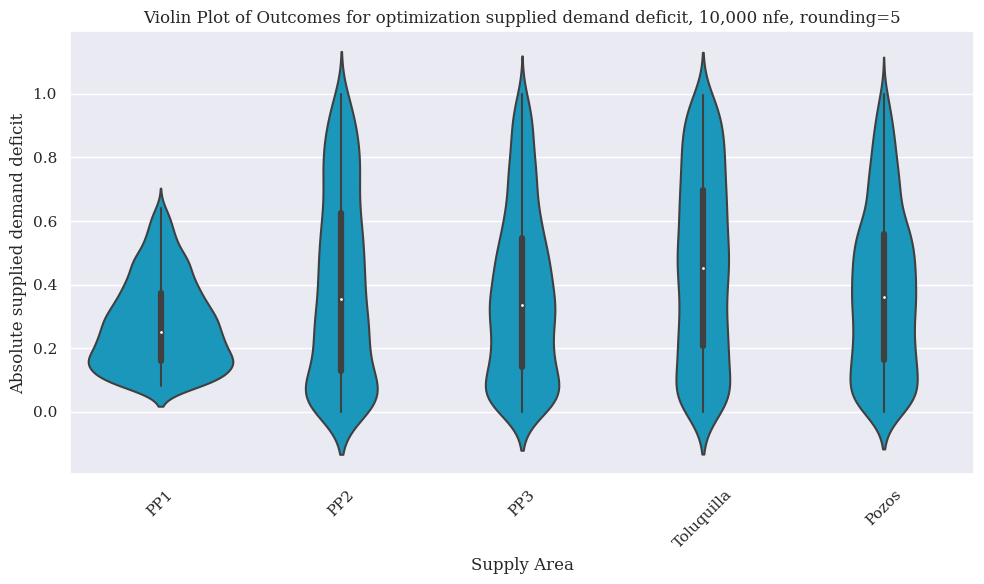

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Assuming 'results' is your dataframe and 'viz_outcomes' is your list of columns
experiment_name = "optimization supplied demand deficit, 10,000 nfe, rounding=5"
viz_outcomes = [f"supplied_demand_deficit_{ZA}" for ZA in ZA_names]
x_axis = "Supply Area"
y_axis = "Absolute supplied demand deficit"

# Set the font to serif
sns.set(font='serif')

# Assuming 'results' is your DataFrame and 'viz_outcomes' is your list of column names
# Assuming 'experiment_name' is a variable containing the experiment name
# Assuming 'ZA_names' is a list containing the names for the x-axis labels
# Assuming 'X_axis' is a variable containing the name for the x-axis
# Assuming 'y_axis' is a variable containing the name for the y-axis

# Create a folder to save the plot if it doesn't exist
folder_path = "experiment_results"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Subset the DataFrame to include only the columns specified in viz_outcomes
viz_data = results[viz_outcomes]

# Melt the DataFrame to long format for plotting
viz_data_melted = viz_data.melt(var_name='Outcome')

# Create the violin plot with customized parameters
plt.figure(figsize=(10, 6))
sns.violinplot(x='Outcome', y='value', data=viz_data_melted, color='#00A6D6', alpha=0.99)
plt.title('Violin Plot of Outcomes for {}'.format(experiment_name))
plt.xlabel(x_axis)
plt.ylabel(y_axis)
plt.xticks(ticks=range(len(ZA_names)), labels=ZA_names, rotation=45)
plt.tight_layout()

# Save the plot to the experiment_results folder with the given experiment name
file_name = os.path.join(folder_path, experiment_name + '_violin_plot.png')
plt.savefig(file_name)

# Show the plot
plt.show()


In [16]:
policies = results.drop(viz_outcomes, axis =1)


In [17]:
# Assuming 'policies' is your DataFrame with columns matching the function parameters
# Create an empty DataFrame to store the results
results_df = pd.DataFrame()

# Iterate over the rows of the policies DataFrame
for index, row in policies.iterrows():
    # Call the AMG_model function with the values from the current row
    outputs = AMG_model_function(**row.to_dict())  # Pass the row values as keyword arguments
    # Append the outputs as a new row to the results DataFrame
    results_df = results_df.append(outputs, ignore_index=True)

# Concatenate the original policies DataFrame with the results DataFrame column-wise
results_df = pd.concat([policies, results_df], axis=1)

# Display or use the results DataFrame as needed
print(results_df)


      aqp1_PP2_to_PP3  aqp2_PP3_to_Pozos  aqp3_Pozos_to_Toluquilla  \
0           -0.414048          -0.326828                 -0.626566   
1            0.070797           0.177771                 -0.083266   
2            0.249705           0.688606                  0.456743   
3           -0.417688           0.121510                  0.036296   
4           -0.202227           0.125757                  0.813087   
...               ...                ...                       ...   
1554         0.009924           0.521203                  0.133126   
1555        -0.425775           0.233895                  0.662250   
1556        -0.109497           0.927181                  0.521626   
1557        -0.101191           0.901716                  0.240272   
1558        -0.214624           0.182178                  0.330552   

      aqp4_Toluquilla_to_PP1  supplied_PP1  supplied_PP2  supplied_PP3  \
0                  -0.356273      2.741547      1.061631      1.451307   
1          

In [18]:
results_df.to_csv("exp_results/test_datafr.csv")

In [19]:
deficit_vars = ["deficit_sq_PP1","deficit_sq_PP2","deficit_sq_PP3","deficit_sq_Toluquilla","deficit_sq_Pozos"]
supplied_demand_vars = ["supplied_demand_PP1","supplied_demand_PP2","supplied_demand_PP3","supplied_demand_Toluquilla","supplied_demand_Pozos"]

# Calculate the average of supplied demands per policy
average_demand_per_policy = results[supplied_demand_vars]

# Create a parallel plot
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")
sns.lineplot(data=average_demand_per_policy.T, dashes=False, markers="o", palette="viridis")

# Set plot labels and title
plt.xlabel('Policy')
plt.ylabel('Supplied Demand')
plt.title('Supplied Demands per Policy')

# Show the plot
plt.show()

KeyError: "None of [Index(['supplied_demand_PP1', 'supplied_demand_PP2', 'supplied_demand_PP3',\n       'supplied_demand_Toluquilla', 'supplied_demand_Pozos'],\n      dtype='object')] are in the [columns]"

## 1.2 Formulation 2 with squared deficits outcomes

## 2. Single scenario with uncertainty (not implemented)


# 3. Multiple drought scenarios, no uncerainty (not implemented)


# Robust optimization


In [ ]:
'''#define a multiplier for all the water flows based on the average 2020 flow that represents drought and possible compensation by other sources
low_flow=0
high_flow=0.7

AMG_model.uncertainties = [RealParameter('chapala_flow',low_flow,6.3*high_flow),
                           RealParameter('calderon_flow',low_flow,1*high_flow),
                           RealParameter('zapotillo_flow',low_flow,1*high_flow),
                           RealParameter('pozos_flow',low_flow,0.5*high_flow),
                           RealParameter('toluquilla_flow',low_flow,1*high_flow)]'''